In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['xtick.major.size'] = 18
plt.rcParams['ytick.major.size'] = 18
plt.rc('legend', fontsize=20)
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
def parse_nvidia_smi_output(path, start=None, stop=None):
    df = pd.read_csv(path)
    df = df[df["index"] == 0]
    df = df.reset_index(drop=True)
    f, ax = plt.subplots(1,1, figsize=(10,10))

    if start is not None:
        df = df.iloc[start:]
    if stop is not None:
        df = df.iloc[:stop]

    df[' power.draw [W]'] =df[' power.draw [W]'].apply(lambda x: float(x.split(" ")[1])) 
    sns.lineplot(x=list(range(len(df))), y=df[' power.draw [W]'], ax=ax)
    print(df[' power.draw [W]'].mean())

In [ ]:
# parse_nvidia_smi_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/molformer_nvidia-smi_output_1k.csv")
# test_path = "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdbind-rp-molformer-1k_nvidia-smi_test.csv"
# parse_nvidia_smi_output(test_path)

In [ ]:
# parse_nvidia_smi_output(test_path,
                        # start=0, stop=110)

Index(['Socket_0 Power (W)', 'Mem_0 Power (W)', 'GPU_0 Power (W)',
       'GPU_1 Power (W)', 'Socket_1 Power (W)', 'Mem_1 Power (W)',
       'GPU_2 Power (W)', 'GPU_3 Power (W)'],
      dtype='object')


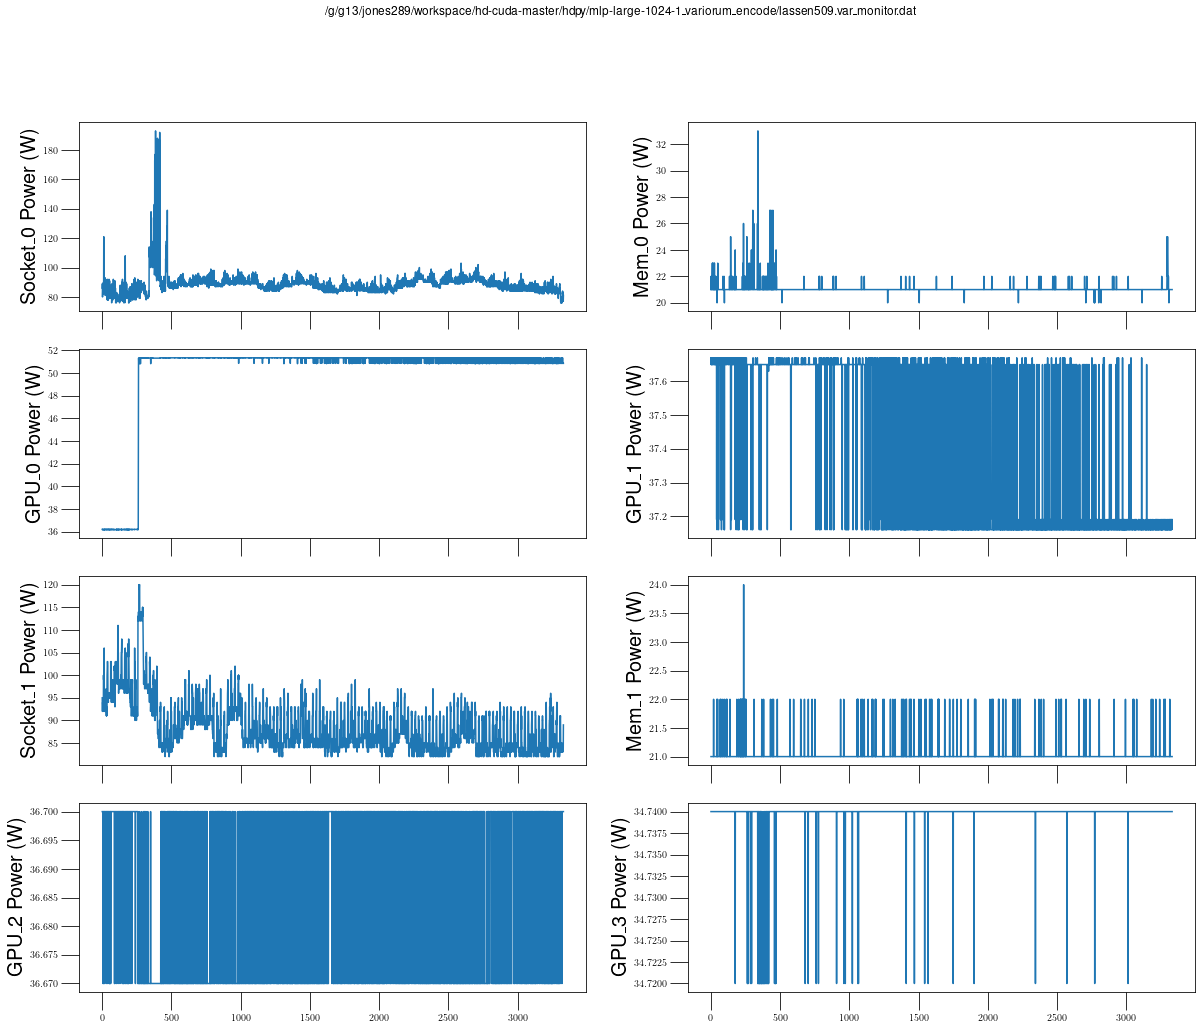

In [3]:
def plot_variorum(path):
    f, ax = plt.subplots(4,2, figsize=(20,16), sharex=True)
    ax = ax.flatten()
    df = pd.read_csv(path)
    cols = df.columns[3:]
    print(cols)

    for idx, col in enumerate(cols):
        
        ax[idx].plot(df[col].values)
        ax[idx].set_ylabel(col)

    f.suptitle(path)


plot_variorum("/g/g13/jones289/workspace/hd-cuda-master/hdpy/mlp-large-1024-1_variorum_encode/lassen509.var_monitor.dat")

In [4]:

TIME_PER_SAMPLE=.05 # this corresponds to milliseconds, sampling interval for variorum
# N=41127
def parse_var_monitor_output(path):
    try:
        path = Path(path)

        mode = path.parent.name.split("_")[-1]
        model = path.parent.name.split("_")[0]
        timing_path = path.parent.parent / Path(f"{model}_timing_{mode}.npy")
        timing_data = np.load(timing_path)
        N, mean_time_crit, std_time_crit = timing_data


        df = pd.read_csv(path)
        gpu_power = df['GPU_0 Power (W)'].values.mean()
        cpu_power = df[['Socket_0 Power (W)', 'Socket_1 Power (W)']].mean().sum()
        
        total_time = TIME_PER_SAMPLE * df.shape[0]
        mean_time = total_time / N


        cpu_energy = cpu_power * (mean_time - mean_time_crit)
        # crit_energy = (cpu_power + gpu_power) * mean_time_crit
        crit_energy = (gpu_power) * mean_time_crit


        result_dict = {
                        "path": path, "model": model, "mode": mode,
                        "cpu_power": cpu_power, "gpu_power": gpu_power,
                        "mean_time_crit": mean_time_crit, "std_time_crit": std_time_crit, 
                        # "total_time": total_time, "mean_time": total_time/N,
                        "mean_time_cpu": mean_time - mean_time_crit,
                        "cpu_energy": cpu_energy,
                        "crit_energy": crit_energy
                       }
        
        return pd.DataFrame(result_dict, index=[0])

    except Exception as e:
        print(e)
        return

def collect_energy_metrics(path_list):
    result_list = []
    for p in path_list:
        result_list.append(parse_var_monitor_output(p))
        # plot_variorum(p)

    df = pd.concat([x for x in result_list if x is not None])
    df = df.reset_index(drop=True)
    return df

In [7]:
# result_dir = "profile_1718776537"
# result_dir = "profile_1718914056"
result_dir = "profile_1718916517"
encode_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{result_dir}").glob("*_variorum_encode/*.dat"))
test_path_list = list(Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/{result_dir}").glob("*_variorum_test/*.dat"))

encode_df = collect_energy_metrics(encode_path_list)
test_df = collect_energy_metrics(test_path_list)

energy_df = pd.concat([encode_df, test_df])
energy_df

,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,mean_time_cpu,cpu_energy,crit_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,encode,176.183473,36.866435,0.000364,0.000002,0.004164,0.733635,0.013419
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,encode,179.176246,51.614132,0.000258,0.017368,0.011399,2.042494,0.013337
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,encode,158.635819,53.084051,0.000163,0.006335,0.003895,0.617832,0.008667
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,encode,162.790410,34.827464,0.000365,0.000002,0.004115,0.669803,0.012708
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,encode,165.176755,34.600024,0.000365,0.000002,0.004099,0.676991,0.012615
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,test,157.116391,53.246114,0.000254,0.000018,0.014869,2.336125,0.013519
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,test,184.476986,50.555686,0.000252,0.000015,0.010020,1.848439,0.012735
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,test,168.003432,54.483829,0.000253,0.000036,0.009981,1.676913,0.013760
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,test,175.335477,51.205695,0.000335,0.000017,0.007227,1.267084,0.017173
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,test,160.316795,51.744307,0.000199,0.000017,0.005954,0.954463,0.010322


In [14]:
col_list = ["1", "10", "100", "1000", "10000", "100000"]

def screen_cost(df):

    molformer_llm_energy = 1.63E-01

    screen_dict = {"Model": [], "Device":[],	"Encode (J/mol)": [], "Test (J/mol)": []}
    for col_val in col_list:
        screen_dict.update({col_val: []})

    for model, model_df in df.groupby("model"):


        encode_crit_energy = model_df[model_df["mode"] == "encode"]["crit_energy"].values.flatten()[0]
        encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
        # encode_cpu_energy = 0
        encode_energy = encode_crit_energy + encode_cpu_energy


        test_crit_energy = model_df[model_df["mode"] == "test"]["crit_energy"].values.flatten()[0]
        test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
        test_cpu_energy = 0
        test_energy = test_crit_energy + test_cpu_energy

        # print(model, encode_energy, test_energy)

        screen_dict["Model"].append(model)
        screen_dict["Device"].append("GPU")
        

        if "molformer" in model:
            encode_energy += molformer_llm_energy

        screen_dict["Encode (J/mol)"].append(encode_energy)
        screen_dict["Test (J/mol)"].append(test_energy)

        for i in col_list:

            screen_cost = encode_energy + (float(i) * test_energy)
            screen_dict[i].append(screen_cost)
    
    # add FPGA numbers

    hdb_df = df[df["model"].apply(lambda x: "mlp" not in x)]


    fpga_test_energy=1.06426E-05

    for model, model_df in hdb_df.groupby(["model"]):
        # print(model, model_df)

        screen_dict["Model"].append(model)
        screen_dict["Device"].append("FPGA")

        encode_crit_energy = model_df[model_df["mode"] == "encode"]["crit_energy"].values.flatten()[0]
        encode_cpu_energy = model_df[model_df["mode"] == "encode"]["cpu_energy"].values.flatten()[0]
        # encode_cpu_energy = 0
        encode_energy = encode_crit_energy + encode_cpu_energy


        test_cpu_energy = model_df[model_df["mode"] == "test"]["cpu_energy"].values.flatten()[0]
        test_cpu_energy = 0
        test_energy = test_cpu_energy + fpga_test_energy

        if "molformer" in model:
            print("adding LLM encode energy")
            encode_energy += molformer_llm_energy # this is the value of the per/mol energy cost I got from molformer on pascal

        screen_dict["Encode (J/mol)"].append(encode_energy)
        screen_dict["Test (J/mol)"].append(test_energy)

        for i in col_list:

            screen_cost = encode_energy + (float(i) * (test_energy))
            screen_dict[i].append(screen_cost)


    screen_df = pd.DataFrame(screen_dict)

    return screen_df 


screen_df = screen_cost(df=energy_df)
screen_df

adding LLM encode energy
adding LLM encode energy


,Model,Device,Encode (J/mol),Test (J/mol),1,10,100,1000,10000,100000
0,hdbind-directecfp-1k-1,GPU,0.747054,0.013519,0.760573,0.882247,2.098991,14.266432,135.940839,1352.684908
1,hdbind-molformer-decfp-combo-1k,GPU,2.218831,0.012735,2.231566,2.346179,3.492317,14.953689,129.567417,1275.704691
2,hdbind-rp-molformer-1k,GPU,0.789499,0.013760,0.803258,0.927094,2.165449,14.549001,138.384524,1376.739747
3,mlp-large-1024-1,GPU,0.682511,0.017173,0.699684,0.854242,2.399827,17.855673,172.414132,1717.998728
4,mlp-small-1024-1,GPU,0.689606,0.010322,0.699928,0.792822,1.721769,11.011237,103.905914,1032.852690
5,hdbind-directecfp-1k-1,FPGA,0.747054,0.000011,0.747064,0.747160,0.748118,0.757696,0.853480,1.811314
6,hdbind-molformer-decfp-combo-1k,FPGA,2.218831,0.000011,2.218841,2.218937,2.219895,2.229473,2.325257,3.283091
7,hdbind-rp-molformer-1k,FPGA,0.789499,0.000011,0.789510,0.789605,0.790563,0.800142,0.895925,1.853759


HDB-DECFP (FPGA)
HDB-DECFP (GPU)
HDB-Combo (FPGA)
HDB-Combo (GPU)
HDB-MoLFormer (FPGA)
HDB-MoLFormer (GPU)
MLP-large (GPU)
MLP-small (GPU)


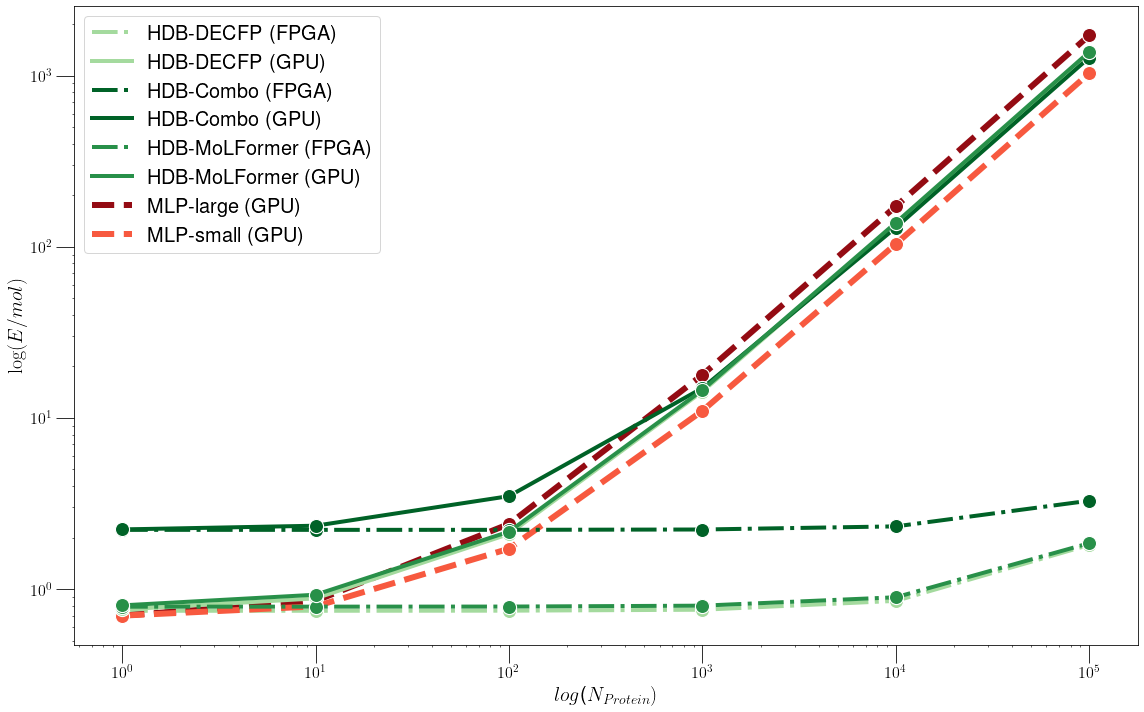

In [15]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
rocket_color_pal = sns.color_palette("rocket", 10)


plot_dict = {
            "mlp-small-1024-1": ("MLP-small", red_color_pal[5]),
            "mlp-large-1024-1": ("MLP-large", red_color_pal[9]),
            "hdbind-molformer-decfp-combo-1k": ("HDB-Combo", green_color_pal[9]),
            "hdbind-directecfp-1k-1": ("HDB-DECFP", green_color_pal[3]),
            "hdbind-rp-molformer-1k": ("HDB-MoLFormer", green_color_pal[7])
    }




def main(df):

    f, ax = plt.subplots(1,1, figsize=(16,10))


    zorder = 1
    for idx, ((model, device), model_df) in enumerate(df.groupby(["Model", "Device"])):

        if model in plot_dict.keys():
            x = [int(x) for x in col_list]
            y = model_df[col_list].values.reshape(-1)
            
            color = plot_dict[model][1]

            model_title = f"{plot_dict[model][0]} ({device})"

            print(model_title)


            linestyle = "-"
            label=model_title
            linewidth=4
            s=200
            if "mlp" not in model.lower():
                zorder = idx

                if device == "FPGA":
                    linestyle = "-."
            else:
                linewidth = 6
                zorder = 0
                linestyle = "--"


            sns.lineplot(x=x, y=y, label=label, ax=ax, markers="x", color=color, linestyle=linestyle, linewidth=linewidth,
                                zorder=zorder)
            sns.scatterplot(x=x, y=y, ax=ax, color=color, s=s, zorder=zorder)


    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("$\log(E/{mol})$")
    ax.set_xlabel("$log$($N_{Protein})$")

    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    plt.tight_layout()
    plt.savefig("hdbind_energy.png", dpi=450)
main(screen_df)

In [16]:
encode_col_str = 'Encode (J/mol)'
test_col_str = 'Test (J/mol)'
screen_df[encode_col_str] = screen_df[encode_col_str].astype(float)
screen_df[test_col_str] = screen_df[test_col_str].astype(float)

round_df = screen_df.round({encode_col_str: 3, test_col_str: 6, '1': 3, '10': 3, '100': 3, '1000': 3, '10000': 3, '100000': 3})
mlp_large_test_energy = round_df[round_df["Model"] == "mlp-large-1024-1"][test_col_str]
mlp_small_test_energy = round_df[round_df["Model"] == "mlp-small-1024-1"][test_col_str]
round_df["mlp-large_test_improvement"] = round_df.apply(lambda x:  mlp_large_test_energy / x[test_col_str], axis=1)
round_df["mlp-small_test_improvement"] = round_df.apply(lambda x:  mlp_small_test_energy / x[test_col_str], axis=1)
round_df
# round_df[round_df["Model"] == "mlp-large-1024-1"]["Test (J/mol)"]
# print(round_df)
# print(round_df['Encode (J/mol)'])
# round_df.to_latex("hdbind_latex_energy_costs.tex", index=False)

,Model,Device,Encode (J/mol),Test (J/mol),1,10,100,1000,10000,100000,test_improvement
0,hdbind-directecfp-1k-1,GPU,0.747,0.013519,0.761,0.882,2.099,14.266,135.941,1352.685,1.270286
1,hdbind-molformer-decfp-combo-1k,GPU,2.219,0.012735,2.232,2.346,3.492,14.954,129.567,1275.705,1.348488
2,hdbind-rp-molformer-1k,GPU,0.789,0.013760,0.803,0.927,2.165,14.549,138.385,1376.740,1.248038
3,mlp-large-1024-1,GPU,0.683,0.017173,0.700,0.854,2.400,17.856,172.414,1717.999,1.000000
4,mlp-small-1024-1,GPU,0.690,0.010322,0.700,0.793,1.722,11.011,103.906,1032.853,1.663728
5,hdbind-directecfp-1k-1,FPGA,0.747,0.000011,0.747,0.747,0.748,0.758,0.853,1.811,1561.181818
6,hdbind-molformer-decfp-combo-1k,FPGA,2.219,0.000011,2.219,2.219,2.220,2.229,2.325,3.283,1561.181818
7,hdbind-rp-molformer-1k,FPGA,0.789,0.000011,0.790,0.790,0.791,0.800,0.896,1.854,1561.181818
